# CNN & Transfer Learning



**Lernziele**

---
* Sie verstehen was mit Transfer Learning gemeint ist
* Sie können vortrainierte Modelle laden und anpassen
* Sie können Bilder aus Ordnern in Python einlesen
---

Letzte Woche haben Sie ein CNN entwickelt, welches Zahlen erkennen kann. Heute soll es darum gehen sich bereits trainierte Netzwerke zunutze zu machen. Zunächst trainieren Sie ein Modell, dass  Hunde und Katzenrassen unterscheiden kann. In der Übungsaufgabe werden Sie ResNet benutzen, um Lungenentzündungen in Röntgenbilder zu erkennen.

Beim Transfer Learning wird ein bereits trainiertes Model für einen anderes Machine Learning Problem benutzt. 

<img align="center" src="https://pennylane.ai/qml/_images/transfer_learning_general.png" width="400">
<h6 align="center">Pennylane.ai</h6>


Das vortrainierte Model, ist meisten ein Model, das auf sehr vielen allgemeinen Daten trainiert worden ist. Dadurch konnte das Model genug allgemeine Informationen lernen, die auch relevant für ein sehr spezifisches Problem sein können.

ResNet wurde zum Beispiel auf den Daten von ImageNet trainiert. Dieses enthält keine Röntgenbilder. Aber durch das Kombinieren von bereits trainierten Layern vom ResNet Modell und neuen untrainierten Layern,  können wir uns das „Wissen“ von ResNet zunutze machen. 

### Das Trainieren dieser Modelle kann diese Woche dauern!


In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch import sigmoid
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
%run ../utils/utils.py
plt.ion()

MNIST ist ein relativ kleiner Datensatz, und kann deswegen auf einmal in den Arbeitsspeicher geladen werden. Wie schon in der Vorlesung diskutiert, sind Bilder meistens aber größer als die Zahlen in MNIST. Um mit großen Bilddatenmengen umzugehen, gibt es von PyTorch eine eigene Library `torchvision`. Hier sind wichtige Funktionen enthalten, die wir im regulären `torch` nicht haben. 

Auch wichtig zu beachten ist, wie jetzt die Daten gespeichert sind. Wenn Sie in den Ordner `data/images_animals/` navigieren, sehen Sie zwei Ordner. Der erste `train` enthält die Trainingsbilder. Der zweite Ordner `val` enthält die Testdaten. Innerhalb dieser Ordner sind wieder Subordner, die nach dem Label der Bilder benannt sind. Das heißt, dass der z. B. der Ordner `beagel` nur Bilder von Beageln enthält.

Wenn genau so eine Ordnerstruktur vorliegt, kann man die Daten sehr leicht mit `torchvision`einlesen.

Bevor wir aber die Daten einlesen können, müssen wir noch Transformationen der Daten festlegen. 

Erstens sind die Bilder zu groß. Die meisten vortrainierten Modelle erwarten eine Bildgröße von 224 x 224 Pixel, da so groß die Bilder im ImageNet Datensatz sind. Auch müssen die Bilder noch zu einem Tensor konvertiert werden. Als letzter Schritt skalieren wir noch die Daten. Diesmal nehmen wir aber nicht den `minmax` Scaler, sondern normalisieren wir die Bilder. **Wichtig hierbei:** Den Mittelwert und die Standardabweichung von den ImageNet Bilder werden dafür verwendet. Denn mit diesen Bildern wurde ja auch das Netzwerk trainiert.

`transforms.Compose()` funktioniert ähnlich wie `nn.Sequential`. Alle Bilder werden nacheinander durch alle Transformationen geschickt. 

In [2]:
data_transforms = transforms.Compose([
        transforms.Resize((224,224)), #reduziert die Größe des Bildes
        transforms.ToTensor(), #konvertiert das Bild zu einem Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) #Normalisiert die Bilder 

Nachdem die Transformationen definiert wurden, können Sie jetzt ein PyTorch `dataset` erstellen. Diesmal benutzen wir aber die besondere Klasse `datasets.ImageFolder`. Diese besondere Klasse an `dataset` ist genau abgestimmt auf unsere Ordner Struktur. Wir müssen nur den "Path" zu den Bildern angeben, und welche Transformationen wir anwenden wollen.

In [3]:
train_data = datasets.ImageFolder('../data/images_animals/train',data_transforms)
test_data = datasets.ImageFolder('../data/images_animals/val',data_transforms)
train_data

Dataset ImageFolder
    Number of datapoints: 5913
    Root location: ../data/images_animals/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Sie sehen, dass wir insgesamt 5913 Bilder in unserem Trainingsordner haben. Auch werden nochmal die Transformationen aufgeführt, die angewendet werden sollen.

Als letzter Schritt erstellen wir noch die `DataLoader`. Diesmal auch für den Testdatensatz, denn wir können nicht alle Bilder auf einmal laden, und deshalb muss auch die Evaluationen in Batches erfolgen.

In [4]:
torch.manual_seed(1235)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,
                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16,
                                             shuffle=True)

example_batch = datasets.ImageFolder('../data/example_batch',data_transforms)
example_batch = torch.utils.data.DataLoader(example_batch, batch_size=6,shuffle=False)


Sie wissen bis jetzt noch nicht, welche und wie viele verschiedene Klasse wir haben. Wir können uns aus dem Datensatz diese Information holen:

In [5]:
class_names = train_data.classes
print(class_names)
print("\nAnzahl Klassen: ",len(class_names))

# Wir speichern einen Batch, um diesen besser zu analysieren
inputs_example, targets_example = next(iter(example_batch))

['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

Anzahl Klassen:  37


Insgesamt haben wir 37 verschiedene Arten von Hunden und Katzen. Wir können uns die Bilder auch mit einer vorgeschriebenen Funktion anschauen.

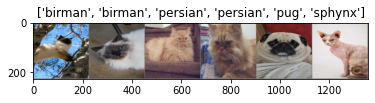

In [6]:
out = torchvision.utils.make_grid(inputs_example[:6])
imshow(out, title=["birman", "birman", "persian", "persian", "pug", "sphynx"])

### RESNET

Wir haben die Daten jetzt im richtigen Format. Bevor wir das Training beginnen können, müssen wir aber auch unser Model in das richtige Format bringen. 
Wie schon erwähnt stellt PyTorch verschiedene, bereits trainierte Modelle zur Verfügung. Diese können einfach geladen werden. *Wenn Sie ein Model zum ersten Mal laden, müssen die Gewichte noch aus dem Internet geladen werden, das kann eventuell dauern.*

Wir verwenden auch nur ResNet18, da alle größeren Netzwerke zu langsam auf den Uniservern trainieren würden.

In [7]:
resnet18 = models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`resnet18` gibt Ihnen eine Übersicht, welche PyTorch Layers in welcher Reihenfolgen benutzt werden. Achten Sie vor allem auf die letzte Layer mit dem Namen `fc`. Dieser können wir auch direkt mit `resnet.fc` auswählen.

In [8]:
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

Diese Layer ist eine `nn.Linear` Layer, welche Sie noch aus dem PyTorch Notebook kennen sollten. Sie hat als Inputgröße 512 Features und als Output 1000. Diese 1000 Output Neuronen entsprechen den 1000 unterschiedlichen Klassen im ImageNet Datensatz.

Um weiter das `resnet` Model vorzubereiten, wollen wir zunächst alle Layers des ResNet einfrieren. Das bedeuet, diese Layers erhalten keine Weight Updates mehr, und können somit nicht weiter trainiert werden. Dies können wir machen, da das Model bereits trainiert worden ist.
Der folgende Code iteriert durch all Layers und setzt `requires_grad` auf `False`. Das lässt PyTorch wissen, dass für diese Layers keine Gradienten berechnet werden müssen. 

In [9]:
for param in resnet18.parameters():
    param.requires_grad = False

Als letzes müssen wir nur noch die `fc` Layer austauschen. Da wir nicht 1000 Klassen, sondern 37. Also brauchen wir eine `nn.Linear` Layer die als Input die Größe 512 hat und als Output die Größe 37.

In [10]:
torch.manual_seed(1234)
resnet18.fc = nn.Linear(512, 37)
print(resnet18.fc)
list(resnet18.fc.parameters())

Linear(in_features=512, out_features=37, bias=True)


[Parameter containing:
 tensor([[-0.0416, -0.0087, -0.0212,  ..., -0.0067,  0.0152,  0.0056],
         [ 0.0368,  0.0257, -0.0321,  ...,  0.0128,  0.0375,  0.0056],
         [-0.0149, -0.0068, -0.0290,  ...,  0.0286,  0.0288, -0.0233],
         ...,
         [-0.0404,  0.0288,  0.0428,  ..., -0.0381,  0.0352,  0.0372],
         [ 0.0101, -0.0175, -0.0290,  ...,  0.0028,  0.0021,  0.0142],
         [-0.0094, -0.0223, -0.0149,  ...,  0.0365, -0.0405, -0.0017]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0342, -0.0060,  0.0187, -0.0274, -0.0063,  0.0318,  0.0225,  0.0347,
         -0.0091,  0.0324, -0.0399, -0.0393,  0.0274,  0.0321, -0.0199,  0.0395,
          0.0288,  0.0321,  0.0073,  0.0099,  0.0152,  0.0370,  0.0144,  0.0185,
         -0.0015,  0.0290, -0.0301, -0.0217,  0.0152,  0.0250,  0.0014,  0.0207,
          0.0284,  0.0400,  0.0142,  0.0150, -0.0417], requires_grad=True)]

Sie können erkennen, dass die neue `fc` Layer `requires_grad=True` gesetzt hat. Das bedeutet diese Weights werden während des Trainings geupdatet. Also ist die `fc` Layer die einzige zu trainiernde Layer im Netzwerk.

## Training 

Jetzt können wir mit dem Trainingsloop beginnen. Doch zunächst definieren wir die Loss Funktion und den Optimizer.

In [11]:
loss_funktion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)

Der Trainingsloop wird heute etwas komplexer aussehen. Das liegt daran, dass wir jetzt auch das Testset als Batches durch das Netzwerk führen. Um trotzdem die Metriken korrekt zu berechnen benutzten wir `running_loss` und `running_corrects`, um diese am Ende des Loops mitteln zu können.
Der Trainingsprozess wird aufgrund er vielen ausgeführten Berechnungen recht lange dauern, auch wenn nur eine Layer tatsächlich trainiert wird.

In [ ]:
torch.manual_seed(3333)
for epoch in range(3):
    
    #### Training ####
    resnet18.train()
    running_loss = 0
    running_corrects = 0
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        output=resnet18(inputs)
        _ , preds = torch.max(output, 1)
        loss = loss_funktion(output,targets)
        running_loss +=loss.item()
        loss.backward()
        optimizer.step()
        running_corrects +=torch.sum(preds == targets.data)   
    epoch_loss = running_loss/len(train_loader)    
    epoch_acc = running_corrects.double() / len(train_data)  
    print('Trainings Loss: {:.4f} Trainings Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))
    
    #### Evaluierung #####
    resnet18.eval()
    running_loss = 0
    running_corrects = 0
    for inputs, targets in tqdm(test_loader):
        output=resnet18(inputs)
        _ , preds =torch.max(output, 1)
        loss = loss_funktion(output,targets)
        running_loss +=loss.item()
        running_corrects +=torch.sum(preds == targets.data)
    epoch_acc = running_corrects.double() / len(test_data) 
    epoch_loss = running_loss/len(test_loader)    
    print('Test Loss: {:.4f} Test Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

  0%|                                                   | 0/370 [00:00<?, ?it/s]/nfs/home/jmenke2/anaconda3/envs/intro_ki/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448204425/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 88%|████████████████████████████████████     | 326/370 [00:55<00:07,  5.80it/s]

Nach drei Epochs erreichen wir bereits eine Testaccuracy von 0.8. 80 Prozent der Bilder werden ungefähr richtig klassifiziert.


Um wirklich sicherzugehen, dass das Pretraining des Models wirklich etwas gebracht hat, trainieren wir das gleiche Model nochmal. Diesmal aber ohne die pretrained Weights zu laden:

`pretrained=False`

In [13]:
resnet18 = models.resnet18(pretrained=False)
torch.manual_seed(1234)
resnet18.fc = nn.Linear(512, 37)
loss_funktion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)
torch.manual_seed(3333)
for epoch in range(3):
    
    #### Training ####
    resnet18.train()
    running_loss = 0
    running_corrects = 0
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        output=resnet18(inputs)
        _ , preds = torch.max(output, 1)
        loss = loss_funktion(output,targets)
        running_loss +=loss.item()
        loss.backward()
        optimizer.step()
        running_corrects +=torch.sum(preds == targets.data)   
    epoch_loss = running_loss/len(train_loader)    
    epoch_acc = running_corrects.double() / len(train_data)  
    print('Trainings Loss: {:.4f} Trainings Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))
    
    #### Evaluierung #####
    resnet18.eval()
    running_loss = 0
    running_corrects = 0
    for inputs, targets in tqdm(test_loader):
        output=resnet18(inputs)
        _ , preds =torch.max(output, 1)
        loss = loss_funktion(output,targets)
        running_loss +=loss.item()
        running_corrects +=torch.sum(preds == targets.data)
    epoch_acc = running_corrects.double() / len(test_data) 
    epoch_loss = running_loss/len(test_loader)    
    print('Test Loss: {:.4f} Test Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

Trainings Loss: 3.3394 Trainings Acc: 0.1010
Test Loss: 3.1745 Test Acc: 0.1273
Trainings Loss: 2.8766 Trainings Acc: 0.1972
Test Loss: 3.0857 Test Acc: 0.1496
Trainings Loss: 2.4863 Trainings Acc: 0.2926
Test Loss: 2.6475 Test Acc: 0.2498


Tatsächlich sind wir nach 3 Epochs nicht ansatzweise bei der Accuarcy die wir erhalten würden, wenn das `pretrained` Model benutzt hätten. Das liegt daran, dass die vortrainierten Convolutions eine Art Feature Generation betreiben.

Wir können das deutlicher sehen, wenn wir uns den die Activations der Convolution anschauen. 
Dazu benutzen wir die Beispielbilder vom Anfang dieses Notebooks.

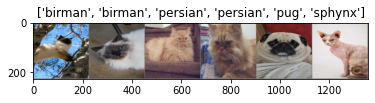

In [16]:
out = torchvision.utils.make_grid(inputs_example[:6])
imshow(out, title=["birman", "birman", "persian", "persian", "pug", "sphynx"])

Zunächst laden wir wieder das vortrainierte Resnet Model. Auch hier entfernen wir die `fc` Layer, aber ersetzen diese nicht durch eine neue linear Layer. Dadurch haben wir direkt Zugriff auf den Output der Convolution Layer. Diese Model nennen wir `resnet_convolutions`.

In [21]:
resnet18 = models.resnet18(pretrained=True)
resnet_convolutions = nn.Sequential(*list(resnet18.children())[:-1])
resnet_convolutions.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Als Letztes führen wir die 6 Bilder von gerade eben durch dieses spezielle Netzwerk und speichern den Output (`feature_encoding`). Dieser Output dient als der Input für die linear Layer, die wir trainieren würden.

<img align="center" src="Img/transferlearning/tf_2.png" width="500">

In [22]:
feature_encodings=resnet_convolutions(inputs_example)[:6,:,0,0]
feature_encodings

tensor([[1.0981, 0.4675, 1.3054,  ..., 0.4823, 0.9077, 0.6025],
        [1.6598, 1.8112, 1.5394,  ..., 0.6307, 0.6150, 0.5705],
        [1.0951, 1.7057, 1.6048,  ..., 1.0916, 0.2039, 0.5692],
        [0.3696, 0.6944, 2.2287,  ..., 1.4618, 0.4856, 0.0266],
        [0.1431, 0.8200, 1.1771,  ..., 1.4739, 0.8521, 0.1429],
        [0.1688, 0.3788, 0.8967,  ..., 0.7485, 0.4448, 0.0794]],
       grad_fn=<SelectBackward>)

Diese „Encodings“ sollen eine Art reduzierte Repräsentation des originalen Bildes sein. Wenn es stimmt, dass die vortrainierten Convolutions bestimmte Features, die relevant für die Klassifizierung sind, finden, dann sollten ähnliche Bilder ähnliche Features haben.

Zum Beispiel das dritte und vierte Bild zeigen jeweils eine `persian` Katze. Die Encodings der Bilder sollten also auch ähnlich sein. Wir können das mithilfe der `cosine_similarity` machen, diese beurteilt, wie ähnlich zwei Vektoren sind. Die Werte liegen immer zwischen -1 (sehr unähnlich) und 1 (sehr ähnlich). 
Wir können die Ähnlichkeit zwischen dem dritten Bild (`persian`) und allen anderen Bildern berechnen.

In [27]:
cosine_similarity(feature_encodings[2:3].detach(),feature_encodings.detach()).round(3)

array([[0.621, 0.804, 1.   , 0.891, 0.593, 0.749]], dtype=float32)

Die Ähnlichkeit vom dritten  Bild zum dritten Bild ist natürlich `1`, da es dasselbe Bild ist. Zu den andere Bilder aber ist die Ähnlichkeit geringer. Am ähnlichsten ist aber das vierte Bild mit `0.891`, diese Bild ist auch ein Bild von einer `persian` Katze. Das heißt, dass dieses vortrainierte Model hat schon gewisse Ähnlichkeiten in den Bildern identifizieren können.   

>Aber die Bilder könnten sich ja auch schon vor den Convolutions ähnlich sein?

Das stimmt, allerdings können wir auch das überprüfen. In der folgenden Zelle berechnen wir die Ähnlichkeit der original Bilder vor den Convolutions.

In [29]:
cosine_similarity(inputs_example.flatten(1)[2:3],inputs_example.flatten(1)[0:6]).round(3)

array([[ 0.058, -0.19 ,  1.   , -0.021, -0.221,  0.131]], dtype=float32)

Hier fällt auf, dass das zweite Bild einer `persian` Katze tatsächlich das unähnlichste ist, obwohl in beiden Bilder die selbe Art von Katze zusehen ist. Wir können also daraus schließen, dass das Netzwerk tatsächlich ähnliche Fetaures in Bildern finden kann.

Als letzes probieren wir noch aus, wie gut unsere Netzwerk funktioniert, wenn wir das vortrainierte Modell laden und unsere eigene Lineare Layer erstellen. Diesmal aber nicht die vortrainierten Convolution Layers nicht einfrieren, also auch noch weiter trainieren.  

In [14]:
resnet18 = models.resnet18(pretrained=True) #PRETRAIN = TRUE
torch.manual_seed(1234)
resnet18.fc = nn.Linear(512, 37) 
loss_funktion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)
torch.manual_seed(3333)
for epoch in range(3):
    
    #### Training ####
    resnet18.train()
    running_loss = 0
    running_corrects = 0
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        output=resnet18(inputs)
        _ , preds = torch.max(output, 1)
        loss = loss_funktion(output,targets)
        running_loss +=loss.item()
        loss.backward()
        optimizer.step()
        running_corrects +=torch.sum(preds == targets.data)   
    epoch_loss = running_loss/len(train_loader)    
    epoch_acc = running_corrects.double() / len(train_data)  
    print('Trainings Loss: {:.4f} Trainings Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))
    
    #### Evaluierung #####
    resnet18.eval()
    running_loss = 0
    running_corrects = 0
    for inputs, targets in tqdm(test_loader):
        output=resnet18(inputs)
        _ , preds =torch.max(output, 1)
        loss = loss_funktion(output,targets)
        running_loss +=loss.item()
        running_corrects +=torch.sum(preds == targets.data)
    epoch_acc = running_corrects.double() / len(test_data) 
    epoch_loss = running_loss/len(test_loader)    
    print('Test Loss: {:.4f} Test Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

Trainings Loss: 1.1286 Trainings Acc: 0.7451
Test Loss: 0.4572 Test Acc: 0.8727
Trainings Loss: 0.2641 Trainings Acc: 0.9457
Test Loss: 0.3624 Test Acc: 0.8917
Trainings Loss: 0.0965 Trainings Acc: 0.9848
Test Loss: 0.3414 Test Acc: 0.8944


Dieses Netzwerk führt zu den besten Ergebnissen. Das liegt daran, dass jetzt auch die Weights der Convolution Layers noch zusätzlich weiter trainiert werden können. Also die Feature-Generation auch abgestimmter auf unseren Datensatz wird. 

In der Praxis werden oft für die neue lineare Layer und die bereits trainierten Convolutions unterschiedliche Learning Rates benutzt. Damit kann die neue lineare Layer schneller trainiert werden als die Convolutions. 

# Übungsaufagbe

Bitte starten Sie wieder den Kernel neu, bevor Sie die Übung machen.

Wie bereits öfter in der Vorlesung besprochen, benutzten wir heute für die Übungsaufgabe ein vortrainiertes Model um Lungenentzündungen an Hand von Röntgenbildern zu erkennen.

Dafür müssen Sie die Daten richtig einlesen, das Model richitg vorbereiten und den `for-loop` richtig ausfüllen.

In [1]:
from __future__ import print_function, division
from torch.nn.functional import sigmoid
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch import sigmoid
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
%run ../utils/utils.py
plt.ion()

Zunächst navigieren Sie zu dem Ordner in dem auch schon die Tierbilder hinterlegt sind. Dort befindet sich auch ein Order `chest_xray`. Auch in diesem befinden sich Subordner mit den jeweiligen Trainings- und Testdatensätzen.
Definieren Sie zunächst welche Transformationen auf die Bilder angewendet werden sollen.

In [ ]:
data_transforms = transforms.Compose([
# resize
# zum Tensor
# Normalisieren    
]) 

Als nächstes laden ersten Sie die relevanten `datasets` und `DataLoader`:

In [ ]:
train_data = datasets.ImageFolder(___________,___________)
test_data = datasets.ImageFolder(___________,____________)
train_data

In [6]:
torch.manual_seed(1235)
train_loader = torch.utils.data.DataLoader(_______, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(_______, batch_size=16, shuffle=True)

Finden Sie heraus wie viele verschiedene Klassen wir haben, denken Sie daran, dass das die Definition unsere Lossfunktion und unseres Netzwerkes beinflusst.

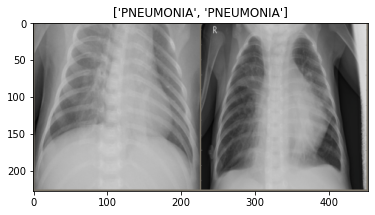

In [9]:
inputs_example, targets_example = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs_example[:2])
imshow(out, title=[class_names[x] for x in targets_example[:2]])

Laden Sie zunächst das **vortrainierte** `resnet18`

In [ ]:
resnet18 = 

Verhindern Sie, dass die `resnet` Layers noch weiter trainiert werden:

In [ ]:
for param in resnet18.parameters():
    ___________________

Ersetzen Sie die richtige Layer mit einer neuen Layer.

In [ ]:
torch.manual_seed(1234)
resnet18.__ =________________ 

Definieren Sie Lossfunktion und Optimizer. Welche Lossfunktion sollten wir für diese Anzahl an Klassen nehmen?

In [ ]:
loss_funktion = 
optimizer = optim.Adam(______________, lr=0.001)

In [50]:
torch.manual_seed(3333)
for epoch in range(3):
    
    #### Training ####
    resnet18._______
    
    #Brauchen wir für die Loss und AUC Berechnung
    running_loss = 0
    pred_ll = []
    targets_ll = []
    
    
    for inputs, targets in tqdm(train_loader):
        optimizer.___________
        
        #Forward Propagation
        output=resnet18(________).squeeze()
        loss = loss_funktion(output,targets.type_as(output))
        
        # Speichern des Loss und der Predictions
        pred_ll.append(sigmoid(output).squeeze().detach().clone().numpy())
        targets_ll.append(targets.detach().numpy())
        running_loss +=loss.item()
        
        # Backpropagation
        loss.___________
        optimizer._____________
         
    epoch_loss = running_loss/len(train_loader)    
    epoch_auc =  roc_auc_score(targets_ll,pred_ll)
    print('Trainings Loss: {:.4f} Trainings AUC: {:.4f}'.format(
        epoch_loss, epoch_auc))
    
    
    #### Evaluierung #####
    resnet18.______
    
    #Brauchen wir für die Loss und AUC Berechnung
    running_loss = 0
    pred_ll = []
    targets_ll = []
    
    for inputs, targets in tqdm(test_loader):
        
        #Forward Propagation
        output=resnet18(_____).squeeze()
        loss = loss_funktion(output,targets.type_as(output))
        
        pred_ll.append(sigmoid(output).squeeze().detach().clone().numpy())
        targets_ll.append(targets.detach().numpy())
        running_loss +=loss.item()

    epoch_auc =  roc_auc_score(targets_ll,pred_ll)
    epoch_loss = running_loss/len(test_loader)    
    print('Test Loss: {:.4f} Test AUC: {:.4f}'.format(
        epoch_loss, epoch_auc))

Trainings Loss: 0.2312 Trainings AUC: 0.9577
Test Loss: 0.4927 Test Auc: 0.9048
Trainings Loss: 0.1320 Trainings AUC: 0.9853
Test Loss: 0.6238 Test Auc: 0.9235
Trainings Loss: 0.1147 Trainings AUC: 0.9890
Test Loss: 0.6882 Test Auc: 0.9448
